In [1]:
import sqlalchemy as sa
import pandas as pd

import json
import logging
import requests

from sqlalchemy.sql import text
from sqlalchemy import inspect
%load_ext autoreload

In [2]:
def get_database_engine(environment: str):
    if environment == 'production':
        url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
        params = requests.get(url).json()['params']
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
        )
    
    elif environment == 'staging':
        with open('alerceread_db_staging.json', 'r', encoding='utf-8') as f:
            params = json.load(f)
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    else:
        raise ValueError(f'Environment "{environment}" not defined')
        
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print('Available Tables:\n', tables)
    return engine

In [3]:
ENVIRONMENT = "production"
engine = get_database_engine(environment=ENVIRONMENT)
engine.begin()

Available Tables:
 ['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [4]:
from astropy.time import Time

min_last_mjd = Time("2025-03-19").mjd
min_first_mjd = Time("2023-03-19").mjd

print(min_last_mjd)

60753.0


In [90]:
#ndet_min = 8
#
## Construimos la consulta SQL
#query = f"""
#    SELECT * FROM object 
#    WHERE firstmjd >= {min_first_mjd} and lastmjd >= {min_last_mjd} and ndet >= {ndet_min};
#"""
#
## Ejecutamos la consulta
#objects = pd.read_sql_query(query, con=engine)
#
#display(objects.head())
#print(objects.shape)
#print(objects.columns)

In [91]:
import glob

#oids = list(objects.oid.values[:2])
oids = ['ZTF24aafnfsk']

## OIDs que no son bogus y tienen igual o más de 8 detecciones

In [92]:
print(f'Num. oids: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
oids_mayor_8 = detections['oid'].value_counts()
oids = oids_mayor_8[oids_mayor_8 >= 8].index
print(f'Num. oids ndet >= 8: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
print(oids)

Num. oids: 1


Num. oids ndet >= 8: 1
["'ZTF24aafnfsk'"]


In [93]:
len(glob.glob('db_production/data/*'))

100

In [98]:
oids = [oid.split('/')[-1].split('.')[0] for oid in glob.glob('db_production/data/*')]
oids = [oids[0]]
oids

['ZTF17aacoobq']

In [99]:
print(f'Num. oids: {len(oids)}')
oids = [f"'{oid}'" for oid in oids]
#
## Construimos la consulta SQL
query = f"""
    SELECT * FROM object 
    WHERE oid IN ({','.join(oids)})
"""

# Ejecutamos la consulta
objects = pd.read_sql_query(query, con=engine)
display(objects.head())
print(objects.shape)
print(objects.columns)

Num. oids: 1


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,meanra,meandec,sigmara,sigmadec,deltajd,firstmjd,lastmjd,step_id_corr,diffpos,reference_change
0,ZTF17aacoobq,855,1268,58041.39419,60753.175197,True,False,549,None,None,...,58.737742,1.723924,0.003073,0.003072,2311.732199,58441.442998,60753.175197,27.5.0,True,False


(1, 22)
Index(['oid', 'ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist',
       'corrected', 'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'meanra', 'meandec', 'sigmara', 'sigmadec', 'deltajd',
       'firstmjd', 'lastmjd', 'step_id_corr', 'diffpos', 'reference_change'],
      dtype='object')


In [100]:
objects[objects.lastmjd > min_last_mjd]

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,meanra,meandec,sigmara,sigmadec,deltajd,firstmjd,lastmjd,step_id_corr,diffpos,reference_change
0,ZTF17aacoobq,855,1268,58041.39419,60753.175197,True,False,549,None,None,...,58.737742,1.723924,0.003073,0.003072,2311.732199,58441.442998,60753.175197,27.5.0,True,False


## Query to BBDD

### Detections and Forced Photometry

In [101]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
display(detections.head())
print(detections.shape)
print(detections.columns)

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF17aacoobq,687442991215015035,58441.442998,1,687442991215,19.826712,1,687,58.737765,1.723944,...,0.0346,455120112.0,16.344122,0.020280,0.021386,True,False,7.112530e+17,False,bulk_1.0.0
1,ZTF17aacoobq,689259181215010002,58443.259190,1,689259181215,19.328447,-1,689,58.737738,1.723949,...,0.1597,455120112.0,17.728073,0.052180,0.057555,True,False,7.112530e+17,False,bulk_1.0.0
2,ZTF17aacoobq,696401161215010010,58450.401169,1,696401161215,19.853800,-1,696,58.737689,1.723879,...,0.3498,NaN,17.315329,0.025061,0.030064,True,False,7.112530e+17,False,bulk_1.0.0
3,ZTF17aacoobq,701291751215010010,58455.291759,2,701291751215,20.512400,-1,701,58.737684,1.723896,...,0.1235,NaN,16.991323,0.019402,0.026816,True,False,7.282193e+17,False,bulk_1.0.0
4,ZTF17aacoobq,701310181215010001,58455.310185,2,701310181215,20.216688,-1,701,58.737745,1.723978,...,0.1026,455120212.0,16.977173,0.018889,0.026280,True,False,7.282193e+17,False,bulk_1.0.0


(526, 30)
Index(['oid', 'candid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')


In [102]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
display(forced_photometry.head())
print(forced_photometry.shape)
print(forced_photometry.columns)

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2999138561215,ZTF17aacoobq,60753.138565,2,58.737818,1.724071,None,None,17.522814,0.023783,...,19.684200,1,0,0.544228,58.737732,1.723946,16.763000,0.015,0.297,-0.021
1,2990146111215,ZTF17aacoobq,60744.146111,1,58.737818,1.724071,None,None,18.336855,0.052836,...,19.433901,1,0,0.514244,58.737740,1.723951,17.130001,0.014,0.612,-0.025
2,2976145041215,ZTF17aacoobq,60730.145046,1,58.737818,1.724071,None,None,17.925959,0.020611,...,20.382200,1,0,0.514244,58.737740,1.723951,17.130001,0.014,0.612,-0.025
3,2976183031215,ZTF17aacoobq,60730.183032,2,58.737818,1.724071,None,None,18.097439,0.034888,...,19.673300,1,0,0.544228,58.737732,1.723946,16.763000,0.015,0.297,-0.021
4,2978130841215,ZTF17aacoobq,60732.130845,1,58.737818,1.724071,None,None,19.277224,0.050208,...,20.518600,1,0,0.514244,58.737740,1.723951,17.130001,0.014,0.612,-0.025


(159, 42)
Index(['pid', 'oid', 'mjd', 'fid', 'ra', 'dec', 'e_ra', 'e_dec', 'mag',
       'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos',
       'corrected', 'dubious', 'parent_candid', 'has_stamp', 'field', 'rcid',
       'rfid', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'magzpsci',
       'magzpsciunc', 'magzpscirms', 'clrcoeff', 'clrcounc', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'programid', 'procstatus',
       'distnr', 'ranr', 'decnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr'],
      dtype='object')


### To compute Features locally

In [103]:
def patch_wise(oid_list):
    columns = ["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]
    df = pd.DataFrame({"oid": oid_list})  # Fill only the oid column
    for col in columns[1:]:  # Add empty columns for the rest
        df[col] = None
    return df

In [104]:
# REFERENCE
query_reference = f"""
                    SELECT oid, rfid, sharpnr, chinr FROM reference
                    WHERE oid in ({','.join(oids)}) and chinr >= 0;
                    """
reference = pd.read_sql_query(query_reference, con=engine)
#reference = reference.drop_duplicates("rfid")

# XMATCH
query_xmatch = f"""
                SELECT oid, oid_catalog, dist FROM xmatch
                WHERE oid in ({','.join(oids)}) and catid='allwise';
                """
xmatch = pd.read_sql_query(query_xmatch, con=engine)
xmatch = xmatch.sort_values("dist").drop_duplicates("oid")
oid_catalog = [f"'{oid}'" for oid in xmatch["oid_catalog"].values]

#########################################################################################
# ALL WISE
query_wise = f"""
            SELECT oid_catalog, w1mpro, w2mpro, w3mpro, w4mpro FROM allwise
            WHERE oid_catalog in ({','.join(oid_catalog)});
            """
try:
    wise = pd.read_sql_query(query_wise, con=engine).set_index("oid_catalog")
    wise = pd.merge(xmatch, wise, on="oid_catalog", how="outer")
    wise = wise[["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]].set_index("oid")
except:
    wise = patch_wise(oids)
    logging.warning("wise patched")

# PANSTARR
query_ps = f"""
            SELECT oid, sgscore1, sgmag1, srmag1, simag1, szmag1, distpsnr1 FROM ps1_ztf
            WHERE oid in ({','.join(oids)});
            """
ps = pd.read_sql_query(query_ps, con=engine)
ps = ps.drop_duplicates("oid").set_index("oid")
#########################################################################################

xmatch = pd.concat([wise, ps], axis=1).reset_index()

display(reference)
display(xmatch)

,oid,rfid,sharpnr,chinr
0,ZTF17aacoobq,455120212,-0.021,0.297
1,ZTF17aacoobq,455120112,-0.025,0.612


,oid,w1mpro,w2mpro,w3mpro,w4mpro,sgscore1,sgmag1,srmag1,simag1,szmag1,distpsnr1
0,ZTF17aacoobq,NaN,NaN,NaN,NaN,1.0,17.3595,17.0152,16.7646,16.8715,0.520474


In [105]:
import numpy as np
from lc_classifier.utils import (
    all_features_from_astro_objects,
    create_astro_object,
    EmptyLightcurveException,
)

def patch_xmatch_by_oid(oid: str):
    data = {
        "oid": [oid],
        "w1mpro": [np.nan],
        "w2mpro": [np.nan],
        "w3mpro": [np.nan],
        "w4mpro": [np.nan],
        "sgscore1": [np.nan],
        "sgmag1": [np.nan],
        "srmag1": [np.nan],
        "simag1": [np.nan],
        "szmag1": [np.nan],
        "distpsnr1": [np.nan],
    }
    return pd.DataFrame(data)

def dataframes_to_astro_object_list(
    detections,
    forced_photometry,
    xmatch,
    reference,
    features=None,
    data_origin="database",
    verbose=True,
):
    oids = detections["oid"].unique()
    detections.set_index("oid", inplace=True)
    detections.sort_index(inplace=True)
    forced_photometry_columns = forced_photometry.columns
    forced_photometry.set_index("oid", inplace=True)
    forced_photometry.sort_index(inplace=True)
    xmatch.set_index("oid", inplace=True)
    reference_columns = reference.columns
    reference.set_index("oid", inplace=True)
    astro_objects_list = []
    for oid in oids:
        try:
            xmatch_oid = xmatch.loc[[oid]].reset_index()
        except:
            logging.warning("xmatch metadata patched!")
            xmatch_oid = patch_xmatch_by_oid(oid=oid).reset_index()

        assert len(xmatch_oid) == 1
        xmatch_oid = xmatch_oid.iloc[0]
        if oid in forced_photometry.index:
            forced_photometry_oid = forced_photometry.loc[[oid]].reset_index()
        else:
            forced_photometry_oid = pd.DataFrame(columns=forced_photometry_columns)
        print('detections:', detections.shape)
        print('forced_photometry_oid:', forced_photometry_oid.shape)
        if oid in reference.index:
            reference_oid = reference.loc[[oid]].reset_index()
        else:
            reference_oid = pd.DataFrame(columns=reference_columns)
        try:
            ao = create_astro_object(
                data_origin=data_origin,
                detections=detections.loc[[oid]].reset_index(),
                forced_photometry=forced_photometry_oid,
                xmatch=xmatch_oid,
                reference=reference_oid,
                non_detections=None,
            )
            if features is not None:
                """add features from db"""
                try:
                    ao.features = features.loc[features.oid == oid][
                        ["name", "value", "fid", "version"]
                    ]
                except:
                    ao.features = None
        except EmptyLightcurveException:
            continue

        astro_objects_list.append(ao)
    return astro_objects_list

In [106]:
output = dataframes_to_astro_object_list(
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=xmatch,
    reference=reference,
    features=None,
)

detections: (526, 29)
forced_photometry_oid: (159, 42)


In [107]:
output[0].detections.sort_values('mjd', ascending=False)

,oid,candid,pid,ra,dec,mjd,brightness,e_brightness,fid,isdiffpos,forced,distnr,rfid,rb,procstatus,tid,sid,unit
aid,,,,,,,,,,,,,,,,,,
aid_ZTF17aacoobq,ZTF17aacoobq,2999175191215015004,2999175191215,58.737818,1.724071,60753.175197,192.504462,14.485925,g,1,False,0.507414,455120112.0,0.968571,NaN,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,2999175191215015004,2999175191215,58.737818,1.724071,60753.175197,16.782598,0.022372,g,1,False,0.507414,455120112.0,0.968571,NaN,ZTF,ZTF,magnitude
aid_ZTF17aacoobq,ZTF17aacoobq,2999138561215015005,2999138561215,58.737759,1.723979,60753.138565,16.315702,0.033970,r,1,False,0.148844,455120212.0,0.928571,NaN,ZTF,ZTF,magnitude
aid_ZTF17aacoobq,ZTF17aacoobq,2999138561215015005,2999138561215,58.737759,1.723979,60753.138565,364.921625,33.813672,r,1,False,0.148844,455120212.0,0.928571,NaN,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,2990146111215010006,2990146111215,58.737739,1.723853,60744.146111,17.646025,0.052178,g,-1,False,0.347662,455120112.0,0.950000,NaN,ZTF,ZTF,magnitude
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF17aacoobq,ZTF17aacoobq,696401161215010010,696401161215,58.737689,1.723879,58450.401169,-80.108758,11.917487,g,-1,False,0.302351,NaN,0.706667,NaN,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,689259181215010002,689259181215,58.737738,1.723949,58443.259190,-216.217479,15.600169,g,-1,False,0.010720,455120112.0,0.766667,NaN,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,689259181215010002,689259181215,58.737738,1.723949,58443.259190,17.728073,0.057555,g,-1,False,0.010720,455120112.0,0.766667,NaN,ZTF,ZTF,magnitude


In [110]:
oid_used = oids[0].strip("'\"")
ao_from_prod = pd.read_pickle(f'db_production/data/{oid_used}.pkl')
print(ao_from_prod.detections.shape)
ao_from_prod.detections.sort_values('mjd', ascending=False)

(1050, 20)


,oid,candid,tid,sid,pid,ra,dec,mjd,brightness,e_brightness,mag,e_mag,fid,isdiffpos,forced,distnr,rfid,rb,procstatus,unit
aid,,,,,,,,,,,,,,,,,,,,
AL25kwczivoyncsem,ZTF17aacoobq,2999138561215015005,ZTF,ZTF,2999138561215,58.737759,1.723979,60753.138565,16.315702,0.033970,17.494501,0.100604,r,1,False,0.148844,455120212.0,0.928571,None,magnitude
AL25kwczivoyncsem,ZTF17aacoobq,2999138561215015005,ZTF,ZTF,2999138561215,58.737759,1.723979,60753.138565,364.921587,33.813670,17.494501,0.100604,r,1,False,0.148844,455120212.0,0.928571,None,diff_flux
NaN,ZTF17aacoobq,2990146111215010006,ZTF,ZTF,2990146111215,58.737739,1.723853,60744.146111,17.646025,0.052178,18.185450,0.085755,g,-1,False,0.347662,455120112.0,0.950000,None,magnitude
NaN,ZTF17aacoobq,2990146111215010006,ZTF,ZTF,2990146111215,58.737739,1.723853,60744.146111,-193.116846,15.253034,18.185450,0.085755,g,-1,False,0.347662,455120112.0,0.950000,None,diff_flux
NaN,ZTF17aacoobq,2985211431215010050,ZTF,ZTF,2985211431215,58.737815,1.723826,60739.211435,-204.349623,23.317173,18.124065,0.123887,r,-1,False,0.516491,455120212.0,0.815714,None,diff_flux
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,ZTF17aacoobq,696401161215010010,ZTF,ZTF,696401161215,58.737689,1.723879,58450.401169,17.315329,0.030064,19.140800,0.161521,g,-1,False,0.302351,NaN,0.706667,None,magnitude
NaN,ZTF17aacoobq,689259181215010002,ZTF,ZTF,689259181215,58.737738,1.723949,58443.259190,17.728073,0.057555,18.062773,0.078336,g,-1,False,0.010720,455120112.0,0.766667,None,magnitude
NaN,ZTF17aacoobq,689259181215010002,ZTF,ZTF,689259181215,58.737738,1.723949,58443.259190,-216.217529,15.600173,18.062773,0.078336,g,-1,False,0.010720,455120112.0,0.766667,None,diff_flux


In [111]:
output[0].forced_photometry.sort_values('mjd', ascending=False)

,oid,candid,pid,ra,dec,mjd,brightness,e_brightness,fid,isdiffpos,forced,distnr,rfid,rb,procstatus,tid,sid,unit
aid,,,,,,,,,,,,,,,,,,
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2999138561215,2999138561215,58.737818,1.724071,60753.138565,16.325180,0.007892,r,1,True,0.544228,455120212.0,NaN,0,ZTF,ZTF,magnitude
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2999138561215,2999138561215,58.737818,1.724071,60753.138565,355.528550,7.787746,r,1,True,0.544228,455120212.0,NaN,0,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2990146111215,2990146111215,58.737818,1.724071,60744.146111,-167.980174,8.174605,g,-1,True,0.514244,455120112.0,NaN,0,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2990146111215,2990146111215,58.737818,1.724071,60744.146111,17.563271,0.025912,g,-1,True,0.514244,455120112.0,NaN,0,ZTF,ZTF,magnitude
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2985113941215,2985113941215,58.737818,1.724071,60739.113947,17.475902,0.021337,g,-1,True,0.514244,455120112.0,NaN,0,ZTF,ZTF,magnitude
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2507282361215,2507282361215,58.737758,1.723914,60261.282361,16.735566,0.005039,r,1,True,0.146154,455120212.0,NaN,0,ZTF,ZTF,magnitude
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2505415281215,2505415281215,58.737758,1.723914,60259.415289,-83.137343,4.597838,g,-1,True,0.149070,455120112.0,NaN,0,ZTF,ZTF,diff_flux
aid_ZTF17aacoobq,ZTF17aacoobq,ZTF17aacoobq2505415281215,2505415281215,58.737758,1.723914,60259.415289,17.322997,0.011681,g,-1,True,0.149070,455120112.0,NaN,0,ZTF,ZTF,magnitude


In [112]:
oid_used = oids[0].strip("'\"")
ao_from_prod = pd.read_pickle(f'db_production/data/{oid_used}.pkl')
print(ao_from_prod.forced_photometry.shape)
ao_from_prod.forced_photometry.sort_values('mjd', ascending=False)

(20, 20)


,oid,candid,tid,sid,pid,ra,dec,mjd,brightness,e_brightness,mag,e_mag,fid,isdiffpos,forced,distnr,rfid,rb,procstatus,unit
aid,,,,,,,,,,,,,,,,,,,,
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2990146111215,ZTF,ZTF,2990146111215,58.737759,1.723979,60744.146111,17.621454,0.027787,18.227081,0.048539,g,-1,True,0.120549,455120112.0,NaN,0,magnitude
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2990146111215,ZTF,ZTF,2990146111215,58.737759,1.723979,60744.146111,-185.852103,8.308748,18.227081,0.048539,g,-1,True,0.120549,455120112.0,NaN,0,diff_flux
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2985113941215,ZTF,ZTF,2985113941215,58.737759,1.723979,60739.113947,-168.942277,7.396113,18.330654,0.047532,g,-1,True,0.120549,455120112.0,NaN,0,diff_flux
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2985113941215,ZTF,ZTF,2985113941215,58.737759,1.723979,60739.113947,17.566326,0.023510,18.330654,0.047532,g,-1,True,0.120549,455120112.0,NaN,0,magnitude
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2980150021215,ZTF,ZTF,2980150021215,58.737759,1.723979,60734.150023,-17.159298,6.956524,20.813751,0.440167,g,-1,True,0.120549,455120112.0,NaN,0,diff_flux
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2980150021215,ZTF,ZTF,2980150021215,58.737759,1.723979,60734.150023,17.167122,0.015310,20.813751,0.440167,g,-1,True,0.120549,455120112.0,NaN,0,magnitude
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2978130841215,ZTF,ZTF,2978130841215,58.737759,1.723979,60732.130845,17.012486,0.006188,19.484779,0.060322,g,1,True,0.120549,455120112.0,NaN,0,magnitude
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2978130841215,ZTF,ZTF,2978130841215,58.737759,1.723979,60732.130845,58.356368,3.242216,19.484779,0.060322,g,1,True,0.120549,455120112.0,NaN,0,diff_flux
AL25kwczivoyncsem,ZTF17aacoobq,ZTF17aacoobq2976183031215,ZTF,ZTF,2976183031215,58.737759,1.723979,60730.183032,16.475088,0.007887,18.057024,0.033858,r,1,True,0.151044,455120212.0,NaN,0,magnitude


In [ ]:
ao_from_prod

In [18]:
from lc_classifier.features.preprocess.ztf import (
    ZTFLightcurvePreprocessor,
)
from lc_classifier.features.composites.ztf import ZTFFeatureExtractor

lightcurve_preprocessor = ZTFLightcurvePreprocessor(drop_bogus=False)

for i in range(len(output)):
    oid = output[i].detections['oid'].values[0]
    lightcurve_preprocessor.preprocess_single_object(output[i])
    feature_extractor = ZTFFeatureExtractor()
    feature_extractor.compute_features_single_object(output[i])
    output[i].features['oid'] = oid
    
#feature_extractor.compute_features_batch(output, progress_bar=False)
#lightcurve_preprocessor.preprocess_batch(output)


In [19]:
output[i].features

,name,value,fid,sid,version,oid
0,g-r_mean,-0.103286,"g,r",ZTF,1.0.0,ZTF24aafnfsk
1,g-r_max,-0.293000,"g,r",ZTF,1.0.0,ZTF24aafnfsk
2,g-r_mean_corr,0.611479,"g,r",ZTF,1.0.0,ZTF24aafnfsk
3,g-r_max_corr,0.491525,"g,r",ZTF,1.0.0,ZTF24aafnfsk
0,W1-W2,NaN,None,ZTF,1.0.0,ZTF24aafnfsk
...,...,...,...,...,...,...
3,mean_chinr,0.982000,"g,r",ZTF,1.0.0,ZTF24aafnfsk
0,Timespan,374.934967,None,ZTF,1.0.0,ZTF24aafnfsk
0,Coordinate_x,-0.458554,None,ZTF,1.0.0,ZTF24aafnfsk
1,Coordinate_y,0.841501,None,ZTF,1.0.0,ZTF24aafnfsk


In [55]:
mapping_bands = {'g': 1, 'r': 2, 'g,r': 12, None: 0, np.nan: 0}

mapping_feat = {
'Power_rate_1_2': 'Power_rate_1/2', 
'Power_rate_1_3': 'Power_rate_1/3', 
'Power_rate_1_4': 'Power_rate_1/4',
}

In [56]:
feat_local = output[0].features.sort_values('name').reset_index(drop=True)
feat_local.fid.replace(mapping_bands, inplace=True)
feat_local.fid = feat_local.fid.astype(int)
feat_local.name.replace(mapping_feat, inplace=True)
feat_local

/tmp/ipykernel_3552773/2871678819.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat_local.fid.replace(mapping_bands, inplace=True)
/tmp/ipykernel_3552773/2871678819.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feat_local.fid.replace(mapping_bands, inplace=True)
/tmp/ipykernel_3552773/2

,name,value,fid,sid,version,oid
0,Amplitude,0.152316,1,ZTF,1.1.0,ZTF24aafnfsk
1,Amplitude,0.029303,2,ZTF,1.1.0,ZTF24aafnfsk
2,AndersonDarling,0.327626,1,ZTF,1.1.0,ZTF24aafnfsk
3,AndersonDarling,0.208146,2,ZTF,1.1.0,ZTF24aafnfsk
4,Autocor_length,1.000000,1,ZTF,1.1.0,ZTF24aafnfsk
...,...,...,...,...,...,...
204,ulens_t0,323.812833,1,ZTF,1.0.2,ZTF24aafnfsk
205,ulens_tE,9.479520,2,ZTF,1.0.2,ZTF24aafnfsk
206,ulens_tE,17.819386,1,ZTF,1.0.2,ZTF24aafnfsk
207,ulens_u0,1.412850,1,ZTF,1.0.2,ZTF24aafnfsk


In [58]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.5.0';
                """

feat_prod = pd.read_sql_query(query_features, con=engine)
feat_prod

,oid,name,value,fid,version
0,ZTF24aafnfsk,Amplitude,0.152315,1,27.5.0
1,ZTF24aafnfsk,Amplitude,0.029303,2,27.5.0
2,ZTF24aafnfsk,AndersonDarling,0.327628,1,27.5.0
3,ZTF24aafnfsk,AndersonDarling,0.208144,2,27.5.0
4,ZTF24aafnfsk,Autocor_length,1.000000,1,27.5.0
...,...,...,...,...,...
204,ZTF24aafnfsk,ulens_u0,1.412847,1,27.5.0
205,ZTF24aafnfsk,ulens_u0,1.641727,2,27.5.0
206,ZTF24aafnfsk,W1-W2,0.822000,0,27.5.0
207,ZTF24aafnfsk,W2-W3,2.466000,0,27.5.0


In [61]:
features_comparison = feat_local.merge(feat_prod, on=['oid', 'name', 'fid'], suffixes=('_local', '_prod'))
features_comparison

,name,value_local,fid,sid,version_local,oid,value_prod,version_prod
0,Amplitude,0.152316,1,ZTF,1.1.0,ZTF24aafnfsk,0.152315,27.5.0
1,Amplitude,0.029303,2,ZTF,1.1.0,ZTF24aafnfsk,0.029303,27.5.0
2,AndersonDarling,0.327626,1,ZTF,1.1.0,ZTF24aafnfsk,0.327628,27.5.0
3,AndersonDarling,0.208146,2,ZTF,1.1.0,ZTF24aafnfsk,0.208144,27.5.0
4,Autocor_length,1.000000,1,ZTF,1.1.0,ZTF24aafnfsk,1.000000,27.5.0
...,...,...,...,...,...,...,...,...
204,ulens_t0,323.812833,1,ZTF,1.0.2,ZTF24aafnfsk,323.812848,27.5.0
205,ulens_tE,9.479520,2,ZTF,1.0.2,ZTF24aafnfsk,9.479550,27.5.0
206,ulens_tE,17.819386,1,ZTF,1.0.2,ZTF24aafnfsk,17.819444,27.5.0
207,ulens_u0,1.412850,1,ZTF,1.0.2,ZTF24aafnfsk,1.412847,27.5.0


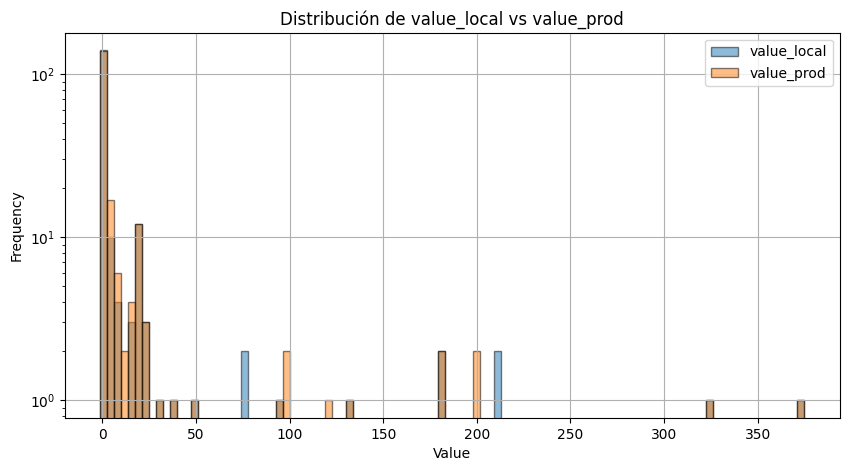

In [107]:
import matplotlib.pyplot as plt

# Extraer las columnas
values_local = features_comparison['value_local']
values_prod = features_comparison['value_prod']

# Crear el histograma
plt.figure(figsize=(10, 5))
plt.hist(values_local, bins=100, alpha=0.5, label='value_local', edgecolor='black', log=True)
plt.hist(values_prod, bins=100, alpha=0.5, label='value_prod', edgecolor='black', log=True)

# Etiquetas y título
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribución de value_local vs value_prod')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [121]:
features_comparison['value_diff'] = abs(features_comparison['value_local'] - features_comparison['value_prod'])
feat_diff_sorted = features_comparison.sort_values('value_diff', ascending=False)[['name', 'value_local', 'value_prod', 'value_diff', 'fid']]

feat_equal = feat_diff_sorted[feat_diff_sorted['value_diff'] == 0]
feat_diff = feat_diff_sorted[feat_diff_sorted['value_diff'] != 0]
feat_nan = feat_diff_sorted[feat_diff_sorted['value_diff'].isna()]

print(f'Num. of different features: {feat_diff.shape[0]}')
print(f'Num. of features without difference: {feat_equal.shape[0]}')
print(f'Num. of features with NaN: {feat_nan.shape[0]}')

display(feat_diff_sorted.style.apply(lambda row: ['' for col in row], axis=1))

Num. of different features: 174
Num. of features without difference: 35
Num. of features with NaN: 24


,name,value_local,value_prod,value_diff,fid
118,SPM_gamma,1.000000,120.000000,119.000000,1
123,SPM_tau_rise,75.458068,100.000000,24.541932,1
124,SPM_tau_rise,75.549371,99.900513,24.351142,2
117,SPM_gamma,1.000000,16.410402,15.410402,2
120,SPM_t0,212.642136,198.500343,14.141793,1
119,SPM_t0,212.621141,198.537251,14.083890,2
115,SPM_chi,2.230297,3.235702,1.005406,1
175,mean_chinr,0.982000,1.562036,0.580036,12
114,SPM_beta,0.027614,0.337980,0.310367,1
113,SPM_beta,0.038225,0.219035,0.180810,2
